Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout,Input, SpatialDropout1D, Bidirectional
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Data load, source [British airways reviews](https://www.kaggle.com/datasets/lapodini/british-airway-reviews)

In [ ]:
base_data = pd.read_csv("BA_AirlineReviews.csv")
base_data.columns



Index(['Unnamed: 0', 'OverallRating', 'ReviewHeader', 'Name', 'Datetime',
       'VerifiedReview', 'ReviewBody', 'TypeOfTraveller', 'SeatType', 'Route',
       'DateFlown', 'SeatComfort', 'CabinStaffService', 'GroundService',
       'ValueForMoney', 'Recommended', 'Aircraft', 'Food&Beverages',
       'InflightEntertainment', 'Wifi&Connectivity'],
      dtype='object')

In [ ]:
base_data=base_data[['OverallRating','ReviewHeader','VerifiedReview','ReviewBody']]
base_data.head()

,OverallRating,ReviewHeader,VerifiedReview,ReviewBody
0,1.0,"""Service level far worse then Ryanair""",True,4 Hours before takeoff we received a Mail stat...
1,3.0,"""do not upgrade members based on status""",True,I recently had a delay on British Airways from...
2,8.0,"""Flight was smooth and quick""",False,"Boarded on time, but it took ages to get to th..."
3,1.0,"""Absolutely hopeless airline""",True,"5 days before the flight, we were advised by B..."
4,1.0,"""Customer Service is non existent""",False,"We traveled to Lisbon for our dream vacation, ..."


In [ ]:
base_data.isnull().sum()

OverallRating     5
ReviewHeader      0
VerifiedReview    0
ReviewBody        0
dtype: int64

In [ ]:
base_data.dropna(inplace=True)


In [ ]:
base_data['VerifiedReview'].value_counts()

False    2543
True     1153
Name: VerifiedReview, dtype: int64

In [ ]:
base_data['OverallRating'].value_counts()

1.0     865
2.0     424
3.0     406
8.0     370
10.0    330
7.0     313
9.0     310
4.0     254
5.0     234
6.0     190
Name: OverallRating, dtype: int64

Grouping ratings in ranges 1-3, 4-7, 8-10

In [ ]:
base_data['OverallRating'] = np.where(base_data['OverallRating'].between(1,3), 0, base_data['OverallRating'])
base_data['OverallRating'] = np.where(base_data['OverallRating'].between(4,7), 1, base_data['OverallRating'])
base_data['OverallRating'] = np.where(base_data['OverallRating'].between(8,10), 2, base_data['OverallRating'])

<Axes: >

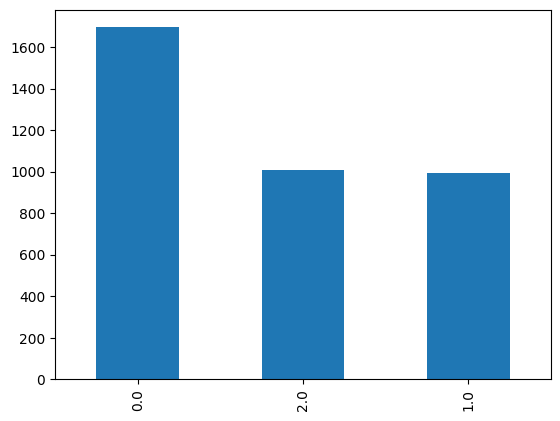

In [ ]:
base_data.OverallRating.value_counts().plot(kind='bar')

In [ ]:
base_data.ReviewHeader.value_counts()

British Airways customer review      951
"never fly British Airways again"      6
"Overall a good flight"                5
"I was pleasantly surprised"           3
"BA has gone downhill"                 3
                                    ... 
"personal space is so tight"           1
"arrived reasonably promptly"          1
"very professional and pleasant"       1
"a fantastic flight"                   1
"cannot fault the service"             1
Name: ReviewHeader, Length: 2684, dtype: int64

In [ ]:
base_data.ReviewHeader.replace(['British Airways customer review'], ' ',inplace=True)

 Delete heading "British Airways customer review" text, and joining heading with main opinion,, also filtring stopwords and cleaning

In [ ]:
base_data.ReviewHeader.value_counts()

                                     951
"never fly British Airways again"      6
"Overall a good flight"                5
"I was pleasantly surprised"           3
"BA has gone downhill"                 3
                                    ... 
"personal space is so tight"           1
"arrived reasonably promptly"          1
"very professional and pleasant"       1
"a fantastic flight"                   1
"cannot fault the service"             1
Name: ReviewHeader, Length: 2684, dtype: int64

In [ ]:
data_fullrev=base_data[['OverallRating','ReviewHeader','ReviewBody']]
data_fullrev['Reviev'] = data_fullrev[['ReviewHeader', 'ReviewBody']].agg(' , '.join, axis=1)
data_fullrev=data_fullrev[['OverallRating','Reviev']]

In [ ]:
data_fullrev.Reviev[0]

'"Service level far worse then Ryanair" , 4 Hours before takeoff we received a Mail stating a cryptic message that there are disruptions to be expected as there is a limit on how many planes can leave at the same time. So did the capacity of the Heathrow Airport really hit British Airways by surprise, 4h before departure? Anyhow - we took the one hour delay so what - but then we have been forced to check in our Hand luggage. I travel only with hand luggage to avoid waiting for the ultra slow processing of the checked in luggage. Overall 2h later at home than planed, with really no reason, just due to incompetent people. Service level far worse then Ryanair and triple the price. Really never again. Thanks for nothing.'

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "[^A-Za-z0-9]"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re
def preproces(text):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
       tokens.append(token)
  return " ".join(tokens)

stemmer restores conjugations and forms of verbs, e.g. running->run. This can help train the network in such a small dataset by reducing irrelevant information.

In [ ]:
data_fullrev.Reviev = data_fullrev.Reviev.apply(lambda x: preproces(x))

In [ ]:
data_fullrev.Reviev[0]

'service level far worse ryanair 4 hours takeoff received mail stating cryptic message disruptions expected limit many planes leave time capacity heathrow airport really hit british airways surprise 4h departure anyhow took one hour delay forced check hand luggage travel hand luggage avoid waiting ultra slow processing checked luggage overall 2h later home planed really reason due incompetent people service level far worse ryanair triple price really never thanks nothing'

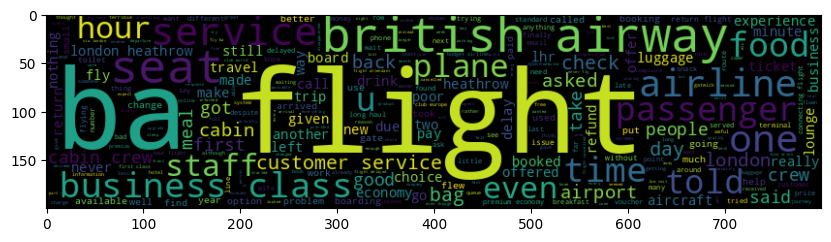

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500 , width = 800 , height = 200).generate(" ".join(data_fullrev[data_fullrev.OverallRating == 0].Reviev))
plt.imshow(wc , interpolation = 'bilinear')

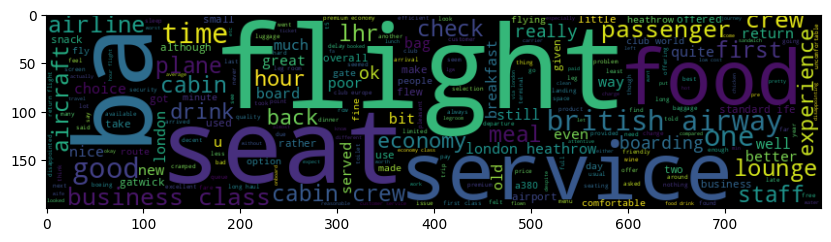

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500 , width = 800 , height = 200).generate(" ".join(data_fullrev[data_fullrev.OverallRating == 1].Reviev))
plt.imshow(wc , interpolation = 'bilinear')

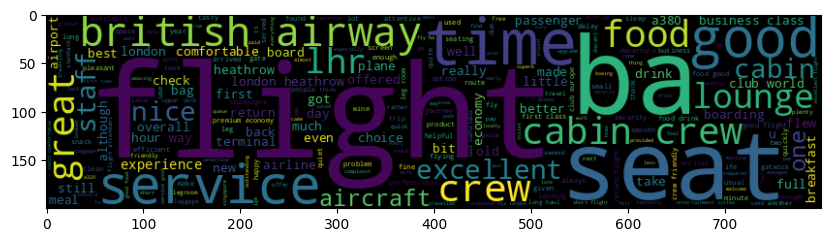

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500 , width = 800 , height = 200).generate(" ".join(data_fullrev[data_fullrev.OverallRating == 2].Reviev))
plt.imshow(wc , interpolation = 'bilinear')

The sets of words from the 3 classes are basically similar and it will be difficult to obtain high accuracy with a small set

Tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_fullrev.Reviev)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

The average number of words per opinion used as the max length of tokenization and glove

In [ ]:
x = data_fullrev.Reviev.apply(lambda x: len(x.split()))
print(x.mean())

87.46320346320347


In [ ]:
sequences = tokenizer.texts_to_sequences(data_fullrev.Reviev)

max_len = 90
data = pad_sequences(sequences, maxlen=max_len)

In [ ]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    3,  467,
        176,  371,  412,  126,   30, 1174,  271, 2225, 2324, 8378,  955,
       8379,  480, 2436,  138,  495,  624,   12, 2542,   18,   57,   48,
       1071,    7,    9, 1024, 4876,  144, 5572,  106,   16,   44,  154,
       1025,   23,  342,   76,  131,  342,   76,  356,  252, 3504,  381,
       2798,  202,   76,  112, 4393,  180,  216, 6603,   48,  423,   81,
       2154,  100,    3,  467,  176,  371,  412, 6604,  200,   48,   80,
       1005,  122], dtype=int32)

GLOVE

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [ ]:
def load_glove_embeddings(embed_dim):
    glove_embeds = {}
    with open(f'/content/glove.6B.{embed_dim}d.txt') as f:
      for line in f:
       values = line.split()
       word = values[0]
       vec = np.asarray(values[1:], dtype='float32')
       glove_embeds[word] = vec
    return glove_embeds

In [ ]:
embedding_dim = 100
word_embeddings = load_glove_embeddings(embedding_dim)

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
  embedding_vector = word_embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          embedding_dim,
                                          weights=[embedding_matrix],
                                          input_length=max_len,
                                          trainable=False)

In [ ]:

sequence_input = Input(shape=(max_len,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = layers.LSTM(32, return_sequences=True)(embedding_sequences)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

train,test,val

In [ ]:
ratings = data_fullrev['OverallRating'].tolist()
ratings = np.array(ratings)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, ratings,stratify=ratings,test_size=0.2)

In [ ]:
x_train, x_val, y_train,y_val= train_test_split(x_train, y_train,stratify=y_train, test_size=0.15)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val),callbacks=[early_stopping])

Epoch 1/20
79/79 [==============================] - 5s 22ms/step - loss: 0.9742 - accuracy: 0.5378 - val_loss: 0.8647 - val_accuracy: 0.6081
Epoch 2/20
79/79 [==============================] - 1s 14ms/step - loss: 0.8034 - accuracy: 0.6473 - val_loss: 0.8566 - val_accuracy: 0.5878
Epoch 3/20
79/79 [==============================] - 1s 14ms/step - loss: 0.7608 - accuracy: 0.6672 - val_loss: 0.8750 - val_accuracy: 0.5968
Epoch 4/20
79/79 [==============================] - 1s 11ms/step - loss: 0.7242 - accuracy: 0.6982 - val_loss: 0.7382 - val_accuracy: 0.6419
Epoch 5/20
79/79 [==============================] - 1s 10ms/step - loss: 0.6963 - accuracy: 0.6951 - val_loss: 0.7333 - val_accuracy: 0.6779
Epoch 6/20
79/79 [==============================] - 1s 10ms/step - loss: 0.6715 - accuracy: 0.7174 - val_loss: 0.7994 - val_accuracy: 0.6441
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 0.6522 - accuracy: 0.7241 - val_loss: 0.7781 - val_accuracy: 0.6644
Epoch 8/20
79

In [ ]:
def his_comp(history):
    plt.figure(figsize=(25, 15))
    plt.subplot(3, 5,1)

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('accuracy')

    plt.subplot(3, 5,2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('loss')

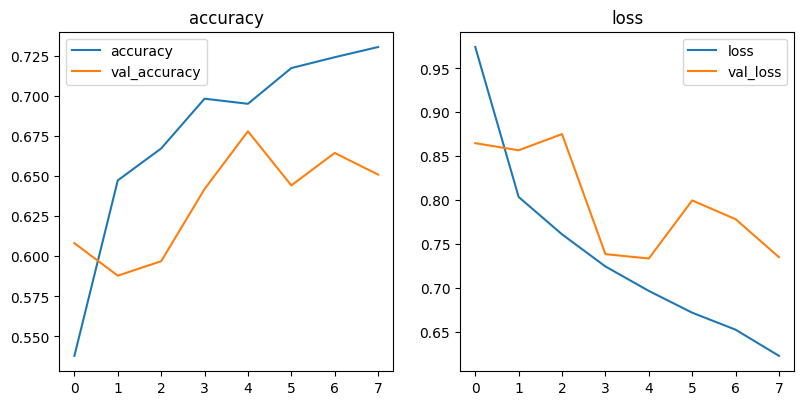

In [ ]:
his_comp(history)

aaa

In [ ]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = layers.LSTM(32, return_sequences=True)(embedding_sequences)
x = layers.LSTM(16)(x)
x = layers.Dropout(0.2)(x)
x = Dense(32, activation='relu', kernel_regularizer=l1(0.01))(x)
outputs = Dense(3, activation='softmax')(x)
model1 = tf.keras.Model(sequence_input, outputs)
model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history1 = model1.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val),callbacks=[early_stopping])

Epoch 1/20
79/79 [==============================] - 5s 27ms/step - loss: 1.6023 - accuracy: 0.5100 - val_loss: 1.3578 - val_accuracy: 0.5991
Epoch 2/20
79/79 [==============================] - 1s 14ms/step - loss: 1.2575 - accuracy: 0.6222 - val_loss: 1.2800 - val_accuracy: 0.6014
Epoch 3/20
79/79 [==============================] - 1s 11ms/step - loss: 1.0746 - accuracy: 0.6489 - val_loss: 1.0456 - val_accuracy: 0.6239
Epoch 4/20
79/79 [==============================] - 1s 11ms/step - loss: 0.9625 - accuracy: 0.6600 - val_loss: 0.9814 - val_accuracy: 0.6239
Epoch 5/20
79/79 [==============================] - 1s 11ms/step - loss: 0.8782 - accuracy: 0.6712 - val_loss: 0.9915 - val_accuracy: 0.6126
Epoch 6/20
79/79 [==============================] - 1s 11ms/step - loss: 0.8222 - accuracy: 0.6939 - val_loss: 0.8742 - val_accuracy: 0.6599
Epoch 7/20
79/79 [==============================] - 1s 11ms/step - loss: 0.7942 - accuracy: 0.6963 - val_loss: 0.8630 - val_accuracy: 0.6419
Epoch 8/20
79

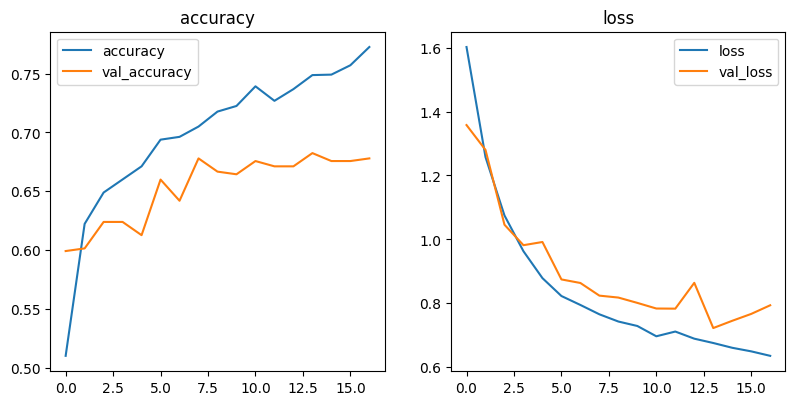

In [ ]:
his_comp(history1)

In [ ]:

sequence_input = Input(shape=(max_len,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.1)(embedding_sequences)

x = Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x=layers.BatchNormalization()(x)
x = Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)

model2 = tf.keras.Model(sequence_input, outputs)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Epoch 1/20
40/40 [==============================] - 10s 55ms/step - loss: 1.0343 - accuracy: 0.4781 - val_loss: 0.9983 - val_accuracy: 0.5113
Epoch 2/20
40/40 [==============================] - 1s 19ms/step - loss: 0.9118 - accuracy: 0.5788 - val_loss: 0.8592 - val_accuracy: 0.6081
Epoch 3/20
40/40 [==============================] - 1s 19ms/step - loss: 0.8131 - accuracy: 0.6389 - val_loss: 0.7824 - val_accuracy: 0.6689
Epoch 4/20
40/40 [==============================] - 1s 19ms/step - loss: 0.7429 - accuracy: 0.6696 - val_loss: 0.7284 - val_accuracy: 0.6779
Epoch 5/20
40/40 [==============================] - 1s 26ms/step - loss: 0.6983 - accuracy: 0.6935 - val_loss: 0.7080 - val_accuracy: 0.6554
Epoch 6/20
40/40 [==============================] - 1s 27ms/step - loss: 0.6635 - accuracy: 0.7158 - val_loss: 0.7001 - val_accuracy: 0.6734
Epoch 7/20
40/40 [==============================] - 1s 26ms/step - loss: 0.6114 - accuracy: 0.7396 - val_loss: 0.6668 - val_accuracy: 0.6937
Epoch 8/20
4

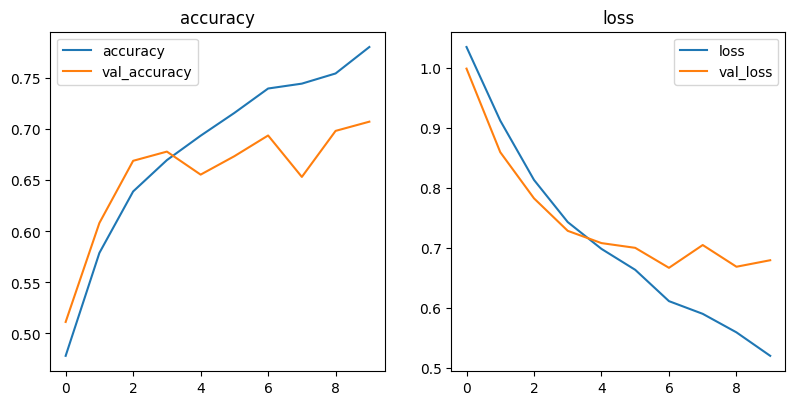

In [ ]:
history2 = model2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val),callbacks=[early_stopping], batch_size=64)
his_comp(history2)

In [ ]:
predictions = model2.predict(x_test)

24/24 [==============================] - 2s 10ms/step


In [ ]:
predicted_classes = predictions.argmax(axis=1)
accuracy = np.mean(predicted_classes == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7040540540540541


In [ ]:
labels=["bad","avg","good"]

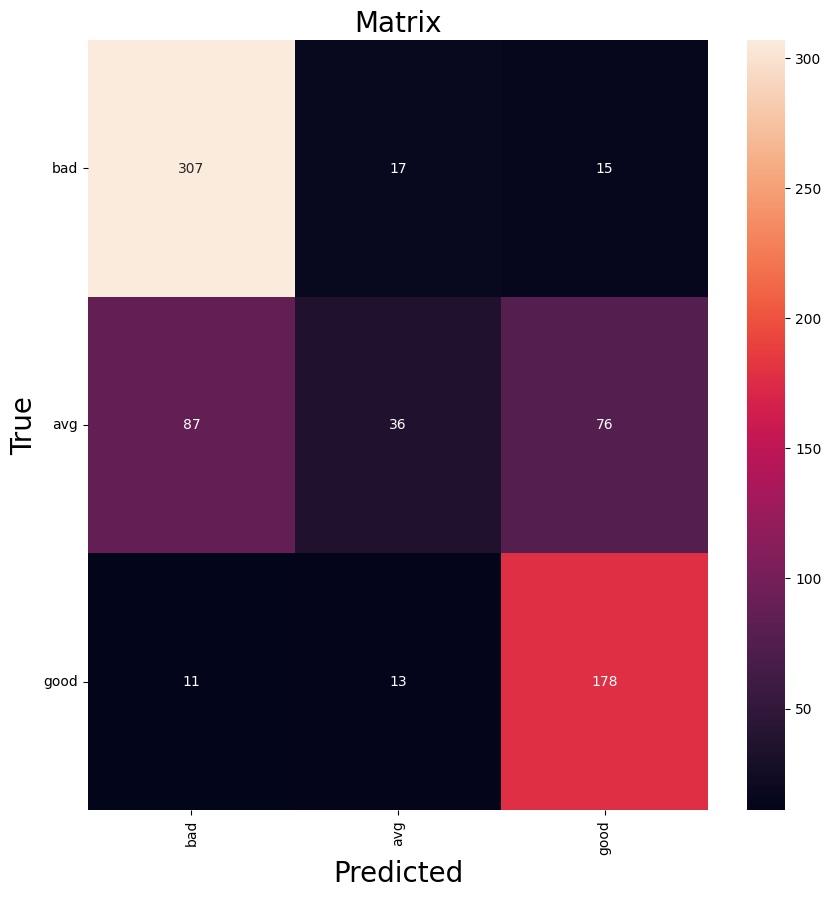

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predicted_classes)

fig = plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')

plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Matrix', fontsize=20)
plt.show()